In [55]:
import os
import re
from typing import List, Tuple, Dict

import pandas as pd
import numpy as np

from konlpy.tag import Mecab
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.stem import WordNetLemmatizer

from dotenv import load_dotenv

load_dotenv()
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

mecab = Mecab(os.environ['MECAB_DIC_PATH'])
stemmer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/jerry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jerry/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [56]:
df = pd.read_csv('./data/link_data.csv').fillna('')
unique_pik = df.pik_id.unique()

pik_to_index = {pik_id: idx for idx, pik_id in enumerate(unique_pik)}
pik_to_num = {row[0]: row[1][0] for row in df.groupby(['pik_id']).count().iterrows()}
pik_to_title = {row[0][0]: row[0][1] for row in df.groupby(['pik_id', 'pik_title']).count().iterrows()}

index_to_pik = {idx: pik_id for idx, pik_id in enumerate(unique_pik)}

In [57]:
def preprocess(text: str):
    
    result = re.sub(pattern=r'[\[\]():|]', repl='', string=text)
    result = re.sub(pattern=r'\s', repl=' ', string=result)
    result = re.sub(pattern=r'[一-龥]', repl='', string=result)
    result = re.sub(pattern=r'[ㄱ-ㅎㅏ-ㅣ]', repl=' ', string=result)

    result.strip()
    result = ' '.join(result.split())

    return result

In [52]:
def extract_noun(text: str, target_pos=['NNG', 'NNP', 'NNB']) -> List[str]:

    def is_noun(word: Tuple(str, str)) -> bool:

        if word[1] in target_pos:
            return True
        elif word[1] == 'SL' and nltk.pos_tag(word[0])[0] == 'NN':
            return True
        return False

    pos_list : List[Tuple[str, str]] = mecab.pos(preprocess(text))
    result = [p[0] for p in pos_list if is_noun(p)]

    return result

In [53]:
tfidf_vectorizer_pik = TfidfVectorizer(tokenizer=lambda x: extract_noun(x), min_df=2, max_features=500)
tfidf_vectorizer_category = TfidfVectorizer(tokenizer=lambda x: extract_noun(x), min_df=2, max_features=500)
tfidf_vectorizer_link = TfidfVectorizer(tokenizer=lambda x: extract_noun(x), min_df=2, max_features=500)
# count_vectorizer = CountVectorizer(tokenizer=lambda x: extract_noun(mecab, x), min_df=2, max_features=5000)

In [54]:
vec_pik = tfidf_vectorizer_pik.fit_transform(df.pik_title)
vec_category = tfidf_vectorizer_category.fit_transform(df.category_title)
vec_memo = tfidf_vectorizer_link.fit_transform(df.memo)

TypeError: Type Tuple cannot be instantiated; use tuple() instead

## K-Means Clustering

In [7]:
concat_matrix = np.concatenate((vec_pik.toarray(), vec_category.toarray(), vec_memo.toarray()), axis=1)
concat_matrix.shape

(43775, 1500)

In [8]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [9]:
Kmeans = KMeans(n_clusters=15)
Kmeans.fit(concat_matrix)

KMeans(n_clusters=15)

In [10]:
labels = Kmeans.predict(concat_matrix)

In [11]:
def extract_data_by_label(target_label: int, labels: List[int]) -> pd.DataFrame:
    target_ids = [idx for idx, label in enumerate(labels) if label == target_label]
    return df.loc[target_ids]

def extract_statics_by_label(target_label: int, labels: List[int]) -> Dict[int, int]:
    target_ids = [idx for idx, label in enumerate(labels) if label == target_label]
    target_df = df.loc[target_ids]
    grouped = target_df.groupby(['pik_id']).count()

    return {row[0]: row[1][0] for row in grouped.iterrows()}

def convert_ratio(target_dict: Dict[int, int]) -> Dict[int, Dict[str, float]]:
    result = {pik_id: {'title': pik_to_title[pik_id], 'ratio': num / pik_to_num[pik_id]} for pik_id, num in target_dict.items()}
    return result

In [15]:
import random
from matplotlib import colors as mcolors


colors = mcolors.TABLEAU_COLORS
by_hsv = {name: mcolors.to_rgba(np.append(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3]), .4))
                for name, color in colors.items()}

color_names = list(by_hsv.keys())
random.shuffle(color_names)

## T-SNE

In [13]:
tsne = TSNE(random_state = 42)
# TSNE에는 transform 메서드가 없으므로 대신 fit_transform을 사용한다.
link_tsne = tsne.fit_transform(concat_matrix)

/home/jerry/anaconda3/envs/tokenizer/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jerry/anaconda3/envs/tokenizer/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/home/jerry/anaconda3/envs/tokenizer/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.


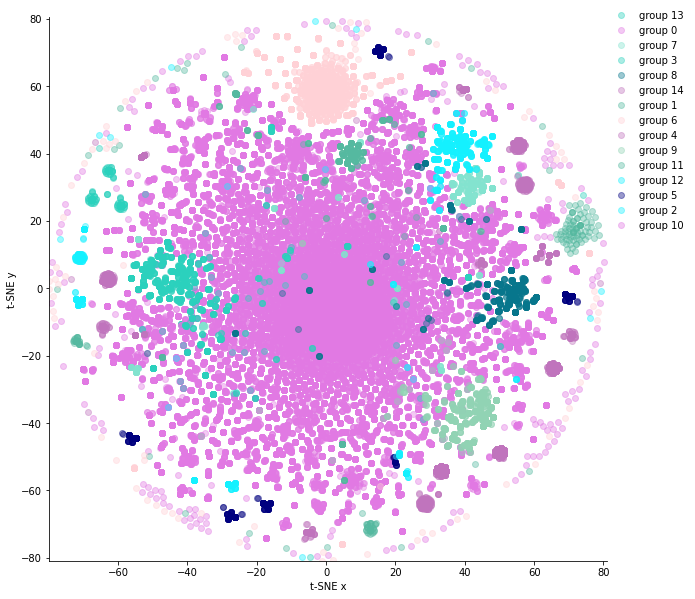

In [16]:
plt.figure(figsize=(10,10))
plt.xlim(link_tsne[:,0].min(), link_tsne[:,0].max()+1)
plt.ylim(link_tsne[:,1].min(), link_tsne[:,1].max()+1)

tsne_point_by_label = dict()

for i in range(len(concat_matrix)):
    label = labels[i]
    try:
        tsne_point_by_label[label]['x'].append(link_tsne[i, 0])
        tsne_point_by_label[label]['y'].append(link_tsne[i, 1])
    except KeyError:
        tmp_dict = {'x': [link_tsne[i, 0]], 'y': [link_tsne[i, 1]]}
        tsne_point_by_label[label] = tmp_dict


for label, coordinates in tsne_point_by_label.items():
    plt.plot(coordinates['x'], coordinates['y'], 'ro', color=by_hsv[color_names[label % 10]], label=f'group {label}')
    
plt.xlabel("t-SNE x")
plt.ylabel("t-SNE y")

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(loc=(1.0, .6), frameon=False)

In [30]:
d= extract_statics_by_label(12, labels)
convert_ratio(d)

{2892: {'title': '동해토박이가 쓰는 동해시 관광 안내서', 'ratio': 0.023809523809523808},
 3152: {'title': '부동산 관련 정보 공유', 'ratio': 0.01694915254237288},
 5188: {'title': '색다른 공간활용 인테리어', 'ratio': 1.0},
 5226: {'title': '유용한 인테리어 정보들!', 'ratio': 1.0},
 5264: {'title': '인테리어 정보 모음', 'ratio': 1.0},
 5282: {'title': '1인 가정 인테리어', 'ratio': 1.0},
 5508: {'title': '인테리어 정보 모음', 'ratio': 1.0},
 5517: {'title': '인테리어 정보 모음', 'ratio': 1.0},
 5542: {'title': '2021 인테리어 트렌드', 'ratio': 0.1111111111111111},
 5550: {'title': '[인테리어 정보]', 'ratio': 1.0},
 5609: {'title': '인테리어의 모든 것', 'ratio': 1.0},
 5622: {'title': '가벼운 마음과 생활, 미니멀라이프', 'ratio': 0.2777777777777778},
 5665: {'title': '인테리어', 'ratio': 1.0},
 5709: {'title': '인테리어 정보 모음', 'ratio': 1.0},
 5794: {'title': '셀프인테리어', 'ratio': 1.0},
 5810: {'title': '포인트 인테리어', 'ratio': 1.0},
 5832: {'title': '인테리어 정보모음', 'ratio': 1.0},
 5929: {'title': '신혼부부 인테리어 정보(랜선 집들이)', 'ratio': 0.9444444444444444},
 5939: {'title': '수납 인테리어 TIP & 추천템', 'ratio': 0.05555555555555555},


In [21]:
d = extract_data_by_label(6, labels)
d.head(20)

,pik_id,category_id,link_id,pik_title,category_title,link_title,link_description,memo,platform,language
53,3948,8246,84218,스터디/교육,미분류,라이프해킹스쿨 패션쇼핑몰,"Facebook에 로그인하세요. 친구, 가족, 지인들과 함께 하는 즐거운 Faceb...",,mobile,ko
56,6525,14331,83928,돈되는 강의 리뷰,미분류,(부업으로 시작했다가) 혼자서 6개월만에 1억 벌고 알게된 6가지 - YouTube,새해 복 많이 받으세요!드로우앤드류 인스타그램 @drawandrew / @drawa...,인타스램으로 돈 많이 벌었던 사람 -드로우앤드류-,\0,ko
83,5965,12561,84536,꼭 읽어보자,미분류,디자이너가 디자이너에게 추천하는 책,다른 디자이너들의 책장을 본다는 것 | 북커버리는 다양한 일하는 사람들의 모든 서재...,서적에 관한 리뷰를 볼 수 있음,web,ko
88,5965,12561,84537,꼭 읽어보자,미분류,"[SOCAR FRAME 만들기 #3] 컴포넌트, 제대로 만들어 쉽게 쓰자! (2탄)",,쏘카 디자인 시스템 정리 블로그,web,ko
111,2873,5654,12753,sad,미분류,http://www.kjh,,asc,,ko
281,2677,5083,11105,회사관련,미분류,IT여성기업인협회,대표설명,회사,,ko
507,5965,12561,84518,꼭 읽어보자,미분류,B2B 프로덕트 디자이너가 신경써야 할 8가지 #2 - 디자이너가 고려해야 하는 점,"그래서, B2B 프로덕트 디자이너는 어떻게 일해야 할까?",,web,ko
683,2974,5889,13341,자동차,미분류,BMW 코딩 나눔터 : 네이버 카페,,,,ko
689,3119,6267,83967,KEEP,미분류,[VC 이끄는 MZ세대]⑧ 김태규 에이벤처스 부사장 “마켓컬리로 60배 수익” - ...,VC 이끄는 MZ세대⑧ 김태규 에이벤처스 부사장 마켓컬리로 60배 수익 컬리 투자로...,\0,\0,ko
767,2999,5949,13549,비트코인 자동매매방법,미분류,위키독스,온라인 책을 제작 공유하는 플랫폼 서비스,코인 자동매매 기술,,ko


In [31]:
mecab.pos('#파이썬')

[('#', 'SY'), ('파이썬', 'NNP')]

In [44]:
import nltk
from nltk.stem import WordNetLemmatizer


nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stemmer = WordNetLemmatizer()

text_text = 'they Python is the most useful programming language'
text_text = [stemmer.lemmatize(i.lower()) for i in text_text.split()]

nltk.pos_tag(text_text)

[nltk_data] Downloading package wordnet to /home/jerry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jerry/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('they', 'PRP'),
 ('python', 'VBP'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('most', 'RBS'),
 ('useful', 'JJ'),
 ('programming', 'NN'),
 ('language', 'NN')]

In [45]:
mecab.pos('hi')

[('hi', 'SL')]

In [59]:
stemmer.lemmatize("geese")

'goose'